In [52]:
from pygeoinf.interval import RadialLaplacian, IntervalDomain, BoundaryConditions, Lebesgue, IntegrationConfig, BesselSobolevInverse
import matplotlib.pyplot as plt
import numpy as np

integration_cfg = IntegrationConfig(method='simpson', n_points=1000)

In [53]:
function_domain = IntervalDomain(1.0, 2.0, open_epsilon=1e-10)
bcs = BoundaryConditions('dirichlet')
M = Lebesgue(100, function_domain, basis='radial_DD', integration_config=integration_cfg)
s = 1
length_scale = 0.5
overall_variance = 1
k = np.power(overall_variance, -0.5/s)
alpha = (length_scale**2) * k**2
L = RadialLaplacian(M, bcs, alpha, method='spectral', dofs=100, integration_config=integration_cfg)
#L = Laplacian(M, bcs, alpha, method='spectral', dofs=100, integration_config=laplacian_integration_cfg)
C_0 = BesselSobolevInverse(M, M, k, s, L, dofs=100, n_samples=2048)

INFO:pygeoinf.interval.operators.radial_operators:RadialLaplacian initialized: method=spectral, dofs=100, ℓ=0, alpha=0.25


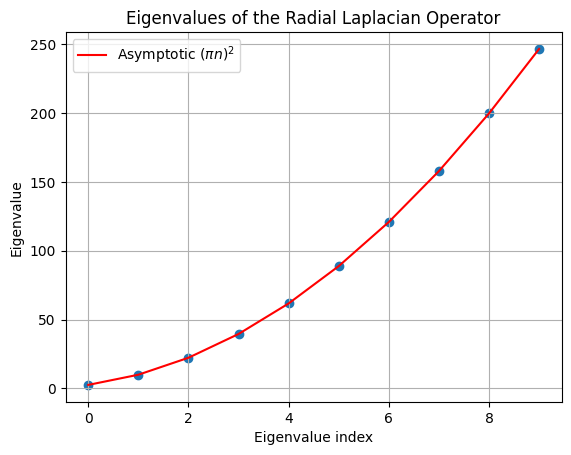

In [54]:
numerical_eigenvalues = [L.get_eigenvalue(i) for i in range(10)]
analytical_eigenvalues_asymptote = [alpha * ((np.pi * (i+1.0))/(function_domain.length))**2 for i in range(10)]
plt.scatter(range(10), numerical_eigenvalues)
plt.plot(range(10), analytical_eigenvalues_asymptote, color='red', label='Asymptotic $(\pi n)^2$')
plt.legend()
plt.xlabel('Eigenvalue index')
plt.ylabel('Eigenvalue')
plt.title('Eigenvalues of the Radial Laplacian Operator')
plt.grid(True)
plt.show()

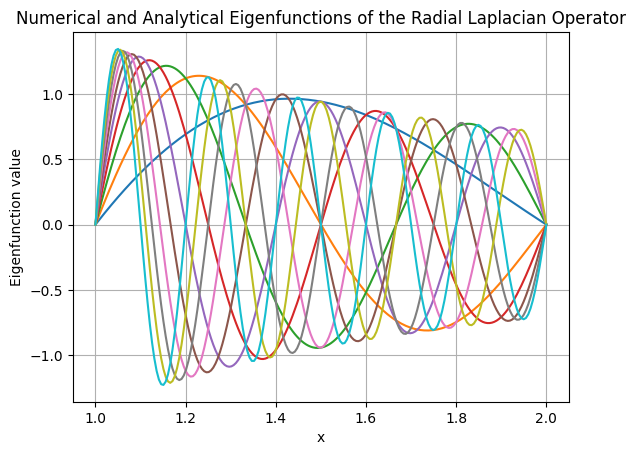

In [55]:
eigenfunctions_numerical = [L.get_eigenfunction(i) for i in range(10)]
analytical_eigenfunctions = [lambda x, n=n: np.sqrt(2/function_domain.length) * (np.sin((n+1) * np.pi * x / function_domain.length))/x for n in range(3)]
for i, ef in enumerate(eigenfunctions_numerical):
    x_vals = function_domain.uniform_mesh(200)
    y_vals = ef.evaluate(x_vals)
    #y_vals_analytical = analytical_eigenfunctions[i](x_vals)
    plt.plot(x_vals, y_vals, label=f'Numerical Eigenfunction {i+1}')
    #plt.plot(x_vals, y_vals_analytical, linestyle='dashed', label=f'Analytical Eigenfunction {i+1}')
#plt.legend()
plt.xlabel('x')
plt.ylabel('Eigenfunction value')
plt.title('Numerical and Analytical Eigenfunctions of the Radial Laplacian Operator')
plt.grid(True)
plt.show()

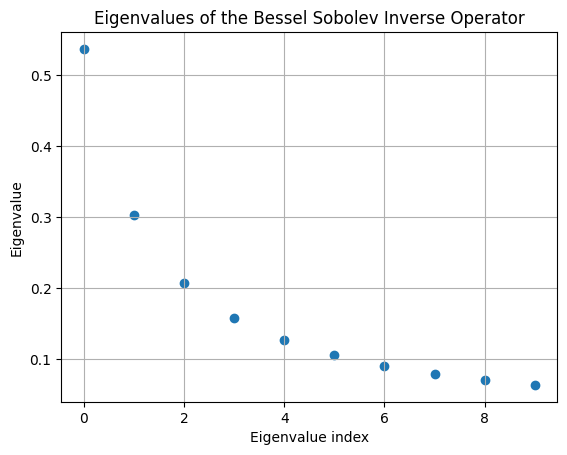

In [56]:
numerical_eigenvalues_C_0 = [C_0.get_eigenvalue(i) for i in range(10)]

plt.scatter(range(10), numerical_eigenvalues_C_0)
plt.xlabel('Eigenvalue index')
plt.ylabel('Eigenvalue')
plt.title('Eigenvalues of the Bessel Sobolev Inverse Operator')
plt.grid(True)
plt.show()

In [57]:
C_0_mat = C_0.matrix(dense=True, parallel=True, n_jobs=8)

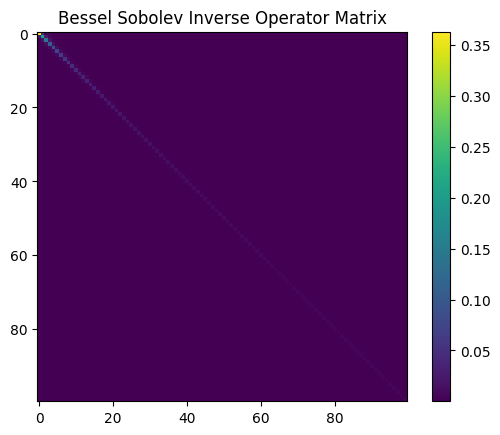

In [58]:
plt.imshow(C_0_mat)
plt.colorbar()
plt.title('Bessel Sobolev Inverse Operator Matrix')
plt.show()

In [59]:
# Comprehensive matrix analysis
print("="*70)
print("MATRIX ANALYSIS")
print("="*70)

# 1. Check symmetry
symmetry_error = np.abs(C_0_mat - C_0_mat.T)
max_symmetry_error = np.max(symmetry_error)
max_element = np.max(np.abs(C_0_mat))
relative_symmetry_error = max_symmetry_error / max_element if max_element > 0 else 0

print(f"\n1. SYMMETRY:")
print(f"   Max absolute symmetry error: {max_symmetry_error:.6e}")
print(f"   Relative symmetry error: {relative_symmetry_error:.6e}")
print(f"   Is symmetric? {relative_symmetry_error < 1e-10}")

# 2. Check if diagonal
diag_elements = np.diag(C_0_mat)
off_diag_mask = ~np.eye(C_0_mat.shape[0], dtype=bool)
off_diag_elements = C_0_mat[off_diag_mask]
max_diag = np.max(np.abs(diag_elements))
max_off_diag = np.max(np.abs(off_diag_elements))
relative_off_diag_error = max_off_diag / max_diag if max_diag > 0 else 0

print(f"\n2. DIAGONALITY:")
print(f"   Max diagonal element: {max_diag:.6e}")
print(f"   Max off-diagonal element: {max_off_diag:.6e}")
print(f"   Relative off-diagonal error: {relative_off_diag_error:.6e}")
print(f"   Is diagonal? {relative_off_diag_error < 1e-10}")

# 3. Check positive definiteness
eigenvals = np.linalg.eigvalsh(C_0_mat)
min_eigenval = eigenvals.min()
max_eigenval = eigenvals.max()
condition_number = max_eigenval / min_eigenval if min_eigenval > 0 else np.inf

print(f"\n3. POSITIVE DEFINITENESS:")
print(f"   Min eigenvalue: {min_eigenval:.6e}")
print(f"   Max eigenvalue: {max_eigenval:.6e}")
print(f"   Condition number: {condition_number:.6e}")
print(f"   Is positive definite? {min_eigenval > 0}")

print("\n" + "="*70)
print(f"SUMMARY: Symmetric={relative_symmetry_error < 1e-10}, "
      f"Diagonal={relative_off_diag_error < 1e-10}, "
      f"PD={min_eigenval > 0}")
print("="*70)

MATRIX ANALYSIS

1. SYMMETRY:
   Max absolute symmetry error: 1.936070e-02
   Relative symmetry error: 5.327519e-02
   Is symmetric? False

2. DIAGONALITY:
   Max diagonal element: 3.634094e-01
   Max off-diagonal element: 4.448697e-02
   Relative off-diagonal error: 1.224156e-01
   Is diagonal? False

3. POSITIVE DEFINITENESS:
   Min eigenvalue: 3.432738e-03
   Max eigenvalue: 3.675415e-01
   Condition number: 1.070695e+02
   Is positive definite? True

SUMMARY: Symmetric=False, Diagonal=False, PD=True
